# Project Attention modulation

> Author: Kai Chen

<img src="project_poster.png" alt="drawing" width="1000"/>

## Objectives
1. Apply rate model to simulate neural activity. 

    **Related functions**
    ```python
    Activation(x)
    GetDr(r, W, nt, drive, t)
    EvolveModel(W, drive, dt)
    get_w(x)
    ```

1. Calculate the neural covaribility, i.e., correlation coeffcient $\rho(\mathbf{r})$, to fit the experimental data.
    - Fine tune the model parameter, including connectivity matrix `W`, input `drive` and attentional modulated input `att_drive`.
    - Theoretically analyze the tuning effect on neural covaribility as functions of different parameters.

    **Related functions**
    ```python
    SpikeCount(N, W,drive_amp, T, dt, begin_seed)
    SpikeCountCorrelation(W)
    ```
1. Build an SNN model using Brian2 
   - Preferentially activate parts of neurons using excitatory attentional drive.
   - Label attention-modulational types of neuron by their firing rate change.
   - Tuning the network property to fit the experimental data of noise correlation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import argparse
import json

In [ ]:

def Activation(x:float)->float:
    """Activation function

    """
    return 0.01*(np.maximum(x,0))**2

def GetDr(r: np.ndarray, W: np.ndarray, drive: np.ndarray) -> np.ndarray:
    """Right hand side of ODEs of the rate model system.
    :param r: float or 1-D array of floats
        the rate of neurons
    :param W: 2-D array of floats
        connectivity matrix
    :param drive: 1-D array of floats
        sum of total inputs of neurons
    :return: float or 1-D array of floats
        the derivative of firing rate of neurons

    """
    # backup note: currently fitting tau [F,S,N] = 69, 31, 50 ms
    return 0.05*( -r + Activation(W@r + drive) )

def EvolveModel(W: np.ndarray, drive: np.ndarray, dt: float) -> np.ndarray:
    """Evolove rate model with forward Euler method.
    :param W: 2D array of floats with shape (neuron# * neuron#),
        weight matrix of connection between populations
    :param drive: np.ndarray of floats with shape (time steps# * neuron#),
        total external drive
    :param dt: time step
    :return: 2D array of floats with shape (#time steps * #populations),
        array of firing rate of populations for each time point

    Example:
    >>> N = 2
    ... T = 1000
    ... dt = 0.5
    ... t = np.arange(0,T,dt)
    ... W = np.ones((N,N))
    ... drive = np.ones((len(t), N)) + np.random.randn(len(t), N)
    ... R = EvolveModel(W, drive, dt)

    """
    # Initialize the system
    tn = len(drive)
    N = W.shape[0]
    # main loop
    R = np.zeros((tn,N))
    R_buffer = np.zeros(N)
    Rmin = 0
    Rmax = 100
    for i in range(tn-1):
        R[i+1] = R[i] + dt* GetDr(R[i], W, drive[i])
        for j in range(N):
            if R[i+1,j]<Rmin:
                R[i+1,j]=Rmin
            elif R[i+1,j]>Rmax:
                R[i+1,j]=Rmax
    return R

def get_w(x:np.ndarray)->np.ndarray:
    """convert parameter list to connectivity matrix
    :param x: array-like list of parameters
    :return: connectivity matrix

    """
    W = np.array([[   .0, x[6], x[0], x[0], x[1], x[1]],
                  [ x[6],   .0, x[0], x[0], x[1], x[1]],
                  [ x[3], x[3],   .0, x[7], x[2], x[2]],
                  [ x[3], x[3], x[7],   .0, x[2], x[2]],
                  [ x[4], x[4], x[5], x[5],   .0, x[8]],
                  [ x[4], x[4], x[5], x[5], x[8],   .0]])
    return W*0.2

## Define ploting functions

In [ ]:

def plot_V_trace(mode: str, x:np.ndarray, visual_drive_amp:tuple,
    attention_drive_amp:tuple, noise_sigma:float, T_header:float,
    dT:float, dt:float, count_range:tuple=None, fname:str=None,
    save = None, **kwargs):

    T = T_header + dT * 200 if mode == 'const' else T_header + dT * 5
    t = np.arange(0, T, dt)
    tn = len(t)
    W = get_w(x)
    if mode == 'const':
        drive_core = 50*np.ones(tn)        # constant drive
        attention_drive_core = 10*np.ones(tn)        # constant drive
    elif mode == 'sine':
        drive_core = 25*(np.sin(4e-3*np.pi*t) + 1)    # drift griding current 2 Hz
        attention_drive_core = 20*np.ones(tn)        # constant drive
    else:
        raise RuntimeError('Invalid mode. Please use either "const" or "sine" mode.')
    # plot sample trace
    fig1 = plt.figure(figsize=(12,8), dpi=400)
    gs1 = fig1.add_gridspec(2,2, left=0.05, right=0.98, top=0.95, bottom=0.10, hspace=0.28, wspace=0.1)
    gs2 = fig1.add_gridspec(2,3, left=0.05, right=0.98, top=0.95, bottom=0.10, hspace=0.28, wspace=0.1)
    ax = []
    ax2 = []
    ax.append(fig1.add_subplot(gs1[0,0]))
    ax.append(fig1.add_subplot(gs1[0,1], sharey=ax[0]))
    ax2.append(fig1.add_subplot(gs2[1,0]))
    ax2.append(fig1.add_subplot(gs2[1,1], sharey=ax2[0]))
    ax2.append(fig1.add_subplot(gs2[1,2], sharey=ax2[0]))
    R = [0,0]
    alphas = [0.5,1]
    # label_suffix = ['_Easy', '_Hard']
    label_suffix = ['', '']
    for i in range(2):
        # noise
        N = len(W)
        drive = np.outer(drive_core, visual_drive_amp) + noise_sigma * np.random.randn(tn, N)
        att_drive = np.outer(attention_drive_core, attention_drive_amp) * i
        drive = drive + att_drive
        # evolve model
        R[i] = EvolveModel(W, drive, dt)
    # -----
        label_set = ['F1', 'F2', 'S1', 'S2', 'N1', 'N2']
        color_set = ['r', 'b', 'y', 'g', 'k', 'm']
        for j in range(N):
            ax[i].plot(np.arange(len(R[i]))*dt, R[i][:,j], color_set[j], lw=.5, label=label_set[j])
        for j in range(3):
            ax2[j].plot(np.arange(len(R[i]))*dt, R[i][:,j*2], color_set[j*2], lw=.5, alpha = alphas[i], label=label_set[j*2]+label_suffix[i])
            ax2[j].plot(np.arange(len(R[i]))*dt, R[i][:,j*2+1], color_set[j*2+1], lw=.5, alpha = alphas[i], label=label_set[j*2+1]+label_suffix[i])
            ax2[j].legend()
            ax2[j].grid(ls='--')

        if count_range is not None:
            for k in range(3):
                ax[i].axvline(T_header + k*dT + count_range[0], ls = '--', color = 'gray')
                ax[i].axvline(T_header + k*dT + count_range[1], ls = '--', color = 'gray')
        ax[i].legend()
        ax[i].set_xlabel('Time (ms)', fontsize=16)
        ax[i].grid(ls='--')
        # ax[0, i].set_ylim(60,100)
    for j in range(3):
        handles, labels = ax2[j].get_legend_handles_labels()
        ax2[j].legend(handles[2:], labels[2:], loc=2, fontsize=15)

    if save is not None:
        np.savez(save, attout = R[0], attin = R[1])
    # -----
    ax[0].set_ylabel('Firing Rate (Hz)',fontsize=16)
    ax[0].set_title('Easy', fontsize = 16)
    ax[1].set_title('Hard', fontsize = 16)
    types = ['F', 'S', 'N']
    for i in range(3):
        ax2[i].set_xlabel('Time (ms)', fontsize=16)
        ax2[i].set_title(types[i]+' Population', fontsize=16)
    ax2[0].set_ylabel('Firing Rate (Hz)', fontsize=16)
    # -----
    if fname is None:
        plt.savefig('sample_trace.png')
    else:
        plt.savefig(fname)
    plt.close()

def make_ax_style(ax: plt.Axes)->plt.Axes:
    # make right and top axis invisible
    ax.axis["right","top"].set_visible(False)

    # make xzero axis (horizontal axis line through y=0) visible.
    ax.axis["xzero"].set_visible(True)
    ax.axis["xzero"].toggle(ticklabels=False)

    # make bottom axis invisiable but remain labels
    ax.axis["bottom"].toggle(all=False, ticklabels=True)
    ax.axis["bottom"].line.set_color('w')
    return ax

def draw_stats_figure(result, figname='sample_figure.png', print_toggle=False):
    from mpl_toolkits.axisartist.axislines import SubplotZero
    easy_data = result[0]
    hard_data = result[1]

    true_val = np.array([ 0.01421889,-0.06871687, 0.07769456, -0.07548139, 0.02734656,-0.01438626])
    true_val_sem = np.array([0.04864358,0.0449311, 0.01826988, 0.04044215,0.04928847,0.01653526])
    x = np.arange(3)
    width = 0.35

    fig = plt.figure(figsize=(6,3), dpi=200)
    ax1 = SubplotZero(fig, 1, 1, 1)
    fig.add_subplot(ax1)
    easy_mean = [easy.mean() for easy in easy_data]
    easy_sem  = [easy.std() for easy in easy_data]
    hard_mean = [hard.mean() for hard in hard_data]
    hard_sem  = [hard.std() for hard in hard_data]

    if print_toggle:
        print('Easy case: ', end=' ')
        print(easy_mean)
        print('Hard case: ', end=' ')
        print(hard_mean)

    ax1.bar(x-width/2, easy_mean, width, color='b', label='Easy', alpha=0.7)
    ax1.bar(x+width/2, hard_mean, width, color='r', label='Hard', alpha=0.7)
    ax1.bar(x-width/2, true_val[0:3], width, yerr=true_val_sem[0:3], color='none', edgecolor='b', ls='--', capsize=3)
    ax1.bar(x+width/2, true_val[3:6], width, yerr=true_val_sem[3:6], color='none', edgecolor='r', ls='--', capsize=3)
    ax1.set_xticks(x)
    labels = ['FN','SN','NN']
    ax1.set_xticklabels(labels,fontsize=35)  # parameterize fontsize doesnot work
    ax1.set_ylabel('Spike Count Correlation',fontsize=35)
    ax1.set_ylim(-0.4,0.4)
    ax1.legend()

    ax1 = make_ax_style(ax1)
    fig.tight_layout()

    if figname is not None:
        plt.savefig(figname)
    return fig

def draw_predict_figure(result, figname='predict_figure.png', print_toggle=True):
    from mpl_toolkits.axisartist.axislines import SubplotZero
    easy_data = result[0]
    hard_data = result[1]

    x = np.arange(3)
    width = 0.35

    fig = plt.figure(figsize=(6,3), dpi=200)
    ax1 = SubplotZero(fig, 1, 1, 1)
    fig.add_subplot(ax1)
    easy_mean = [easy.mean() for easy in easy_data]
    easy_sem  = [easy.std() for easy in easy_data]
    hard_mean = [hard.mean() for hard in hard_data]
    hard_sem  = [hard.std() for hard in hard_data]

    if print_toggle:
        print('Easy case: ', end=' ')
        print(easy_mean)
        print('Hard case: ', end=' ')
        print(hard_mean)

    ax1.bar(x-width/2, easy_mean, width, yerr=easy_sem, color='b', label='Easy', alpha=0.7, capsize=3)
    ax1.bar(x+width/2, hard_mean, width, yerr=hard_sem, color='r', label='Hard', alpha=0.7, capsize=3)
    ax1.set_xticks(x)
    labels = ['FF','FS','SS']
    ax1.set_xticklabels(labels,fontsize=25)  # parameterize fontsize doesnot work
    ax1.set_ylabel('Spike Count Correlation',fontsize=25)
    ax1.set_ylim(-1.,1.)
    ax1.legend()

    ax1 = make_ax_style(ax1)

    if figname is not None:
        plt.savefig(figname)
    return fig

## Plot a sample voltage trace

In [ ]:
# config parameters:
# # define adj-matrix;
mode = 'const'
x = [0, -0.4, -0.2, 0, -1, 2, 0, 0, 0]
fname = 'sample_trace.png'

dT = 50
T_header = 100
dt = 0.1
noise_sigma = 30

# top-down drive modulation ratio, initial estimation:
visual_drive_amp = (1.25, 1.25, 1.35, 1.35, 1.1, 1.1)
attention_drive_amp = (0.25, 0.25, -.35, -.35, 0, 0)

plot_V_trace(mode, x, visual_drive_amp, attention_drive_amp, noise_sigma, T_header, dT, dt)

## Run multiple trials to quantify neural covaribility

Here we use spike count correlation to quantify neural covaribilities. In our rate model, we further use firing rate to represent the spike count per unit time. And the covaribility of firing rate between neurons are quantified as follows

$$
R(r_i, r_j) = \frac{E(r_i-Er_i)E(r_j-Er_j)}{Var(r_i)Var(r_j)}
$$

Tune your model to fit the experimental data shown in the figure below

<img src="./experimental_result.png" alt="experimental result" width=500/>

Data points in the figure.

```python
rsc_mean_easy = np.array([ 0.01421889,-0.06871687, 0.07769456])
rsc_mean_hard = np.array([-0.07548139, 0.02734656,-0.01438626])
rsc_sem_easy = np.array([0.04864358,0.0449311, 0.01826988])
rsc_sem_hard = np.array([0.04044215,0.04928847,0.01653526])
```

In [ ]:
def SpikeCount(mode:str, N:int, W:np.ndarray, visual_drive_amp:tuple,
        attention_drive_amp:tuple, noise_sigma:float, T:float, dt:float,
        begin_seed:int, contrast:float=1.0)->np.ndarray:
    """Evolve rate model N times to record the spike count.
    :param mode: type of drives
    :type mode: str
    :param N: number of trials
    :type N: int
    :param W: connectivity matrix
    :type W: np.ndarray
    :param visual_drive_amp: amplitude of external drive of neurons
    :type visual_drive_amp: 1D tuple of floats
    :param attention_drive_amp: amplitude of attentional drive of neurons
    :type attention_drive_amp: 1D tuple of floats
    :param noise_sigma: standard diviation of gaussian white noise
    :type noise_sigma: float
    :param T: total time period
    :type T: float
    :param dt: time steps, ms
    :type dt: float
    :param begin_seed: seed of first trial
    :type begin_seed: int
    :return: spike count data with size, [N, Nt, len(W)]
    :rtype: 3D array of floats

    """

    tn = int(T/dt)
    n_pop = len(W)
    spike_count = np.empty((N, tn, n_pop))
    if mode == 'const':   # constant drive
        drive_core = 50*np.ones(tn)
        attention_drive_core = 10*np.ones(tn)
    elif mode == 'sine':  # drift griding current 2 Hz
        drive_core = 25*(np.sin(4e-3*np.pi*np.arange(0,T,dt)))*contrast + 25
        attention_drive_core = 20*np.ones(tn)
    else:
        raise TypeError('Invalid mode. Please use either "const" or "sine" mode.')
    conti_drive = np.outer(drive_core, visual_drive_amp)
    attention_drive = np.outer(attention_drive_core, attention_drive_amp)
    for i in range(N):
        # noise
        np.random.seed(begin_seed + i)
        noise_common_weight = 5*np.array([-3,-3,-1,-1,2,2]) # add common noise to shift the level of scc
        noise_common = np.random.randn(tn)
        noise = noise_sigma*np.random.randn(tn, n_pop)
        for j in range(n_pop):
            noise[:, j] += noise_common * noise_common_weight[j]
        # evolve model
        R = EvolveModel(W, conti_drive + attention_drive + noise, dt)
        spike_count[i] = R
    return spike_count

def ClassifyNeuronTypes(spike_count_no_attention:np.ndarray, spike_count_with_attention:np.ndarray)->np.ndarray:
    """Classify neuron in three types according to their attentional index(AR).
    :param spike_count_no_attention: spike count in without-attention case.
    :param spike_count_with_attention: spike count in with-attention case.
    :return: array of cell types. 0:=Facilitative, 1:=Suppressive, 2:=Null.

    """
    cell_types = np.zeros(spike_count_no_attention.shape[2], dtype=int)
    mean_firing_rate_no_attention = spike_count_no_attention.mean(1).squeeze()
    mean_firing_rate_with_attention = spike_count_with_attention.mean(1).squeeze()
    #print(mean_firing_rate_no_attention)
    #print(mean_firing_rate_with_attention)
    firing_rate_deviation = ((mean_firing_rate_with_attention - mean_firing_rate_no_attention)/mean_firing_rate_no_attention)
    #print(firing_rate_deviation)
    mfr_thred = .05
    cell_types[firing_rate_deviation>=mfr_thred] = 0
    cell_types[firing_rate_deviation<=-mfr_thred] = 1
    cell_types[(firing_rate_deviation<mfr_thred) & (firing_rate_deviation>-mfr_thred)] = 2
    return cell_types

def SpikeCountCorrelation(spike_counts:np.ndarray, cell_types:np.ndarray)->np.ndarray:
    """Calcualte spike count correlation from spike count data
    :param spike_counts: #trials by #populations, or #trials by #times by #populations;
    :param cell_types: len == #populations;
    :return: spike count correlations
    :rtype: array-like object with len == 6

    """
    ntype = 3
    if len(spike_counts.shape) == 2:
        ncc = np.corrcoef(spike_counts.transpose())
        ncc_buffer = np.zeros((ntype, ntype))
        for i in range(ntype):
            for j in range(i+1):
                if i == j:
                    ncc_buffer[i,j] = ncc[cell_types==i][:,cell_types==j][~np.eye(np.sum(cell_types==i), dtype=bool)].mean()
                else:
                    ncc_buffer[i,j] = ncc[cell_types==i][:,cell_types==j].mean()
        ncc_buffer = np.array([ncc_buffer[2,0],      # FN
                               ncc_buffer[2,1],      # SN
                               ncc_buffer[2,2],      # NN
                               ncc_buffer[0,0],      # FF
                               ncc_buffer[1,0],      # FS
                               ncc_buffer[1,1]])     # SS
    elif len(spike_counts.shape) == 3:
        ncc_buffer = np.zeros((ntype, ntype), dtype=np.ndarray)
        for k in range(spike_counts.shape[1]):
            ncc = np.corrcoef(spike_counts[:,k,:].transpose())
            for i in range(ntype):
                for j in range(i+1):
                    if i == j:
                        ncc_buffer[i,j] = np.append(ncc_buffer[i,j],
                                ncc[cell_types==i][:,cell_types==j][np.tril(np.ones((np.sum(cell_types==i), np.sum(cell_types==i)), dtype=bool),-1)])
                    else:
                        ncc_buffer[i,j] = np.append(ncc_buffer[i,j], ncc[cell_types==i][:,cell_types==j])
        for i in range(ntype):
            for j in range(i+1):
                ncc_buffer[i,j] = ncc_buffer[i,j][1:]
        ncc_buffer = np.array([ncc_buffer[2,0],        # FN
                               ncc_buffer[2,1],        # SN
                               ncc_buffer[2,2],        # NN
                               ncc_buffer[0,0],        # FF
                               ncc_buffer[1,0],        # FS
                               ncc_buffer[1,1]])       # SS
    else:
        raise TypeError('Invalid spike_counts. Please use either 2-d or 3-d numpy.array.')
    return ncc_buffer

def main_func(mode:str, x:np.ndarray, visual_drive_amp:tuple, attention_drive_amp:tuple,
        noise_sigma:float, T:float, dt:float, T_header:float, dT:float,
        count_range:tuple=None, **kwargs) -> np.ndarray:
    """Main funciton to evolve system as well as calculate spike count correlation,
        and draw result figure.

    :param mode: type of drives
    :type mode: str
    :param x: parameter of system for connectivity matrix.
    :type x: numpy.ndarray
    :param visual_drive_amp: amplitude of external drive of neurons
    :type visual_drive_amp: 1D tuple of floats
    :param attention_drive_amp: amplitude of attentional drive of neurons
    :type attention_drive_amp: 1D tuple of floats
    :param noise_sigma: standard diviation of gaussian white noise
    :type noise_sigma: float
    :param T: total time period
    :type T: float
    :param dt: time steps, ms
    :type dt: float
    :param T_header: length of time period treated as transient process at the
        begining of the simulation.
    :type T_header: float
    :param dT: Time window of single trial
    :type dT: float

    :param spike_counts: #trials by #populations, or #trials by #times by #populations;
    :return: spike count correlations
    :rtype: array-like object with len == 6

    """
    W = get_w(x)
    print(W)
    if mode == 'const':
        if count_range is not None:
            raise TypeError('Cannot receive "const" mode and count_range simultaneously.')
    elif mode == 'sine':
        if count_range is None:
            raise TypeError('Missing count_range, required in "const" mode.')
        sin_range = [int(item/dt) for item in count_range]
    else:
        raise TypeError('Invalid mode. Please use either "const" or "sine" mode.')
    # Initialize the system
    result = []
    att_drive = ((0)*len(attention_drive_amp), attention_drive_amp)
    cell_types = np.array([0, 0, 1, 1, 2, 2]) # mannually define population cell types.
    for i in range(2):
        begin_seed = np.random.randint(10000000)
        spike_count = SpikeCount(mode, 1, W, visual_drive_amp, att_drive[i], noise_sigma, T, dt, begin_seed, **kwargs)
        # remove T_header unstable region
        spike_count = spike_count[:,int(T_header/dt):,:]
        spike_count = spike_count.reshape((-1, int(dT/dt), len(W)))
        if mode == 'const':
            ncc_buffer = SpikeCountCorrelation(spike_count, cell_types)
        elif mode == 'sine':
            spike_count_mean = spike_count[:,sin_range[0]:sin_range[1],:].mean(1)
            ncc_buffer = SpikeCountCorrelation(spike_count_mean, cell_types)
        else:
            raise TypeError('Invalid mode. Please use either "const" or "sine" mode.')
        result.append(ncc_buffer)
    return result

[[ 0.     0.216 -0.1   -0.1    0.28   0.28 ]
 [ 0.216  0.    -0.1   -0.1    0.28   0.28 ]
 [-0.06  -0.06   0.     0.184  0.035  0.035]
 [-0.06  -0.06   0.184  0.     0.035  0.035]
 [-0.26  -0.26  -0.06  -0.06   0.     0.02 ]
 [-0.26  -0.26  -0.06  -0.06   0.02   0.   ]]


/usr/share/miniconda/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


It takes 74.00 s.


Easy case:  [-0.11307927762616007, -0.012933446108566688, 0.12476607903146034]
Hard case:  [-0.0710754173592919, -0.027422877550499426, 0.09901109434851282]


Rscc save to sample_figure_20211208-074515.png
Voltage trace save to vol_trace_20211208-074515.png
Model parameters save to cfg_20211208-074515.json


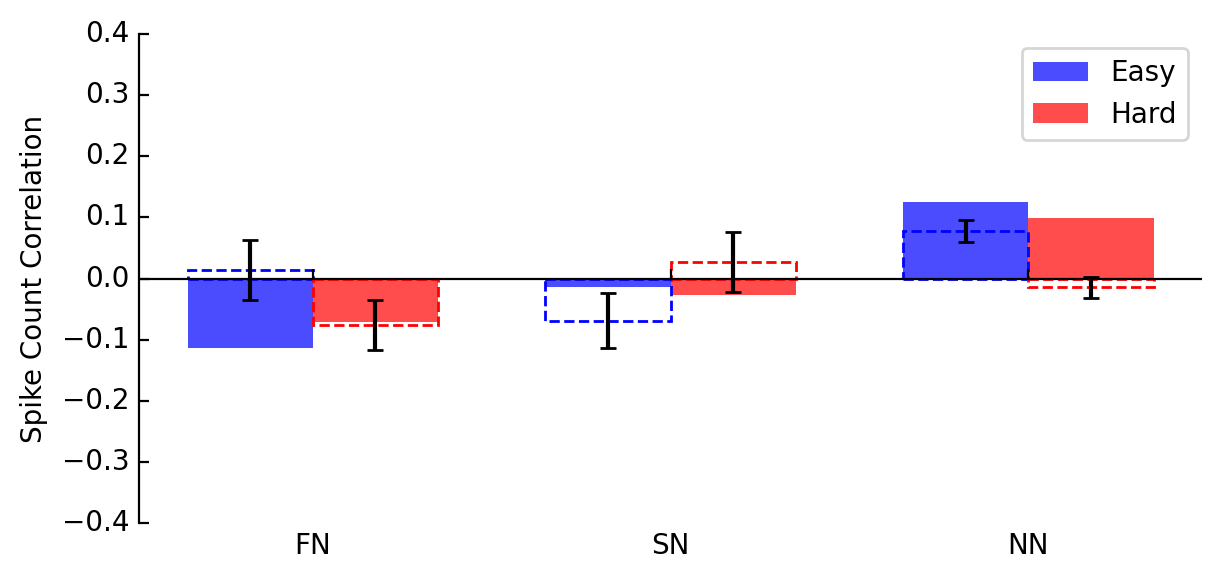

In [ ]:
t_start = time.time()
pm = {}
if mode == 'sine':
    pm['T']  = 3000500
    pm['T_header'] = 500
    pm['dT'] = 500
    pm['count_range'] = (10,240)
elif mode == 'const':
    pm['T'] = 800200
    pm['T_header'] = 200
    pm['dT'] = 20
    pm['count_range'] = None
else:
    raise TypeError('Invalid mode. Please use either "const" or "sine" mode.')
# top-down modulation, initial estimation:
pm['visual_drive_amp'] = tuple(np.array([1.45, 1.45, 1.60, 1.60, 1.7, 1.7]))
pm['attention_drive_amp'] = [0.2 , 0.2, -.2, -.2 , 0.0, 0.0]
pm['noise_sigma'] = 40
pm['dt'] = 0.5
pm['x'] = (-0.5,1.4,0.175,-0.3,-1.3,-0.3,1.08,0.92,0.1)
pm['mode']= 'const'

timestr = time.strftime("%Y%m%d-%H%M%S")
plot_V_trace(fname = 'vol_trace_'+timestr+'.png', save = 'V_data'+timestr+'.npz', **pm)

result = main_func(**pm)

np.save('scc_data_'+timestr+'.npy', result)
t_finish = time.time()
print('It takes %5.2f s.' % (t_finish-t_start))

stat_result = [result[0][:3], result[1][:3]]
draw_stats_figure(stat_result, 'sample_figure_'+timestr+'.png', True)
print('Rscc save to sample_figure_'+timestr+'.png')
print('Voltage trace save to vol_trace_'+timestr+'.png')
with open("cfg_"+timestr+".json", "w") as write_file:
    json.dump(pm, write_file, indent=2)
print('Model parameters save to cfg_'+timestr+'.json')

# Uncomment below to draw the model prediction about other pairs of correlation.
# pred_result = [result[0][3:], result[1][3:]]
# draw_predict_figure(pred_result, 'predict_figure_'+timestr+'.png', True)
# print('Rscc (prediction) save to predict_figure_'+timestr+'.png')

The dashed bars above is the experimental data where the solid bars are the simulated results. Please tune the parameter to make your model results fit the experimental data.